## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### Part I - Probability

To get started, let's import our libraries.

In [72]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
random.seed(42)

### Read in the dataset and take a look at the top few rows here:

In [73]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Use the below cell to find the number of rows in the dataset.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Number of rows = 294478

### The number of unique users in the dataset.

In [75]:
print("The number of unique users: {}".format(df['user_id'].nunique()))

The number of unique users: 290584


### The proportion of users converted.

In [76]:
print("The proportion of users converted: {}".format(df['converted'].mean()))

The proportion of users converted: 0.11965919355605512


### The number of times the `new_page` and `treatment` don't line up.

In [77]:
df['group'].unique()

array(['control', 'treatment'], dtype=object)

In [78]:
df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

In [79]:
print("The number of times the new_page and treatment don't line up: {}".format(df.query("group == 'control' and landing_page == 'new_page' or group == 'treatment' and landing_page == 'old_page'").group.count()))

The number of times the new_page and treatment don't line up: 3893


### Do any of the rows have missing values?

In [80]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

 As we can see from above there is no missing point.

In [81]:
df.drop(df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"').index,inplace = True);

In [82]:
df2 = df

In [83]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [84]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### How many unique **user_id**s are in **df2**?

In [85]:
df2['user_id'].nunique()

290584

### Repeated **user_id**  in **df2**

In [86]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [87]:
print("Repeated user_id is 773192")

Repeated user_id is 773192


### What is the row information for the repeat **user_id**? 

In [88]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [89]:
df2.drop_duplicates(['user_id'], keep = 'first',inplace = True)

In [90]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


###  What is the probability of an individual converting regardless of the page they receive?

In [91]:
df2['converted'].mean()

0.11959708724499628

###  Given that an individual was in the `control` group, what is the probability they converted?

In [92]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

###  Given that an individual was in the `treatment` group, what is the probability they converted?

In [93]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

###  What is the probability that an individual received the new page?

In [94]:
df.query("landing_page == 'new_page'").landing_page.count()/df['landing_page'].count()

0.5000619442226688

* Given that an individual was in the control group, the probability of converted is 0.12. On the other hand, given that an individual was in the treatment group, the probability of converted is 0.1188. As we can see the control group is leading but the difference is not so much. Then we can not state with certainty that one group is leading another.

<a id='ab_test'></a>
### Part II - A/B Test
 
The hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, we consider that we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? 


* $H_{0}$: $p_{old}$ >= $p_{new}$
* $H_{1}$: $p_{old}$ < $p_{new}$

In other words we can write as follow,
* $H_{0}$: $p_{old}$ - $p_{new} >= 0$
* $H_{1}$: $p_{new}$ - $p_{old} > 0$

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

we will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


###  What is the **convert rate** for $p_{new}$ under the null? 

In [95]:
P_new = df2['converted'].mean()
print("P_new: {}".format(P_new))

P_new: 0.11959708724499628


###  What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [96]:
P_old = df2['converted'].mean()
print("P_old: {}".format(P_old))

P_old: 0.11959708724499628


###  What is $n_{new}$?

In [97]:
n_new = df2.query("group == 'treatment'").group.count()
print("n_new: {}".format(n_new))

n_new: 145310


###  What is $n_{old}$?

In [98]:
n_old = df2.query("group == 'control'").group.count()
print("n_old: {}".format(n_old))

n_old: 145274


###  Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [99]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [P_new, 1-P_new])

###  Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [100]:
old_page_converted = np.random.choice([1,0], size = n_old, p = [P_old, 1-P_old])

###  Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [101]:
new_page_converted = new_page_converted[:145274]
new_page_converted.mean() - old_page_converted.mean()

0.0008535594807054236

###  Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [102]:
p_diffs = []
for _ in range(10000):
    new_page_converted_p = np.random.choice([1,0], size = n_new, p = [P_new, 1-P_new]).mean()
    old_page_converted_p = np.random.choice([1,0], size = n_old, p = [P_old, 1-P_old]).mean()
    p_diffs.append(new_page_converted_p - old_page_converted_p)

###  Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

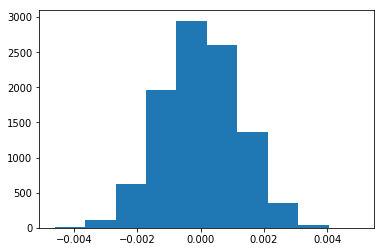

In [103]:
plt.hist(p_diffs);


###  What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [104]:
actual_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
actual_diff = np.array(actual_diff)
(p_diffs > actual_diff).mean()

0.9063

* The scientific name of what we computed above is p_value, which means the probability of obtaining observed statistic if the null hypothesis is true. As we can see here the p_value is high. It means that the null hypothesis is true and we should stay with old pages.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [105]:
import statsmodels.api as sm

convert_old = df2.query("group=='control'").converted.sum()
convert_new = df2.query("group == 'treatment'").converted.sum()
n_old = df2.query("group=='control'").converted.count()
n_new = df2.query("group == 'treatment'").converted.count()

In [106]:
print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17489
17264
145274
145310


###  Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [107]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [108]:
from scipy.stats import norm

norm.cdf(z_score)
norm.ppf(1-(0.05/2))

1.959963984540054

* Since the z_score(1.31) is less than critical value (1.95) we accept the null hypothesis, which is equal to exact conclusion that we reched at parts j and k. The conversion rate of old page is slightly better than the new page as previous parts.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>



In [109]:
df['intercept'] = 1
df[['control','treatment']] = pd.get_dummies(df['group'])

In [110]:
import statsmodels.api as sm
logit = sm.Logit(df['converted'],df[['intercept','treatment']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [113]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-10-29 12:03 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

* The p_value that we calculated in this part is 0.19, which is different from the previous part. The reason for that is because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped or been exclusive to an extent to give different values. The p_value is bigger than 0.05, it means that we failed to reject the null hypotheses and we have to reject alternative. The logistic regression hypothesis is like follow,
* $H_{0}$: $p_{new}$ - $p_{old}  = 0$
* $H_{1}$: $p_{new}$ - $p_{old}  != 0$

In [115]:
df_contries = pd.read_csv('countries.csv')
df_contries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [116]:
df_new = df_contries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [117]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [118]:
df_new[['Canada','USA']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,Canada,USA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,0


In [120]:
log_new = sm.Logit(df_new['converted'],df_new[['intercept','Canada','USA','treatment']])
result_new = log_new.fit()
result_new.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-10-29 12:05 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
Canada       -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
USA          -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
treatment    -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

### Conclusions
* As we can see from above, the p_value for Canada is much better than USA but it is still more than 0.05, also the coef for both cases are negetive. Therefore, we stay with the null and reject the alternate hypothesis. To sum up, we should stay with the old pages.